<a href="https://colab.research.google.com/github/sophiezxh/llm-cot-anxiety/blob/main/DeepseekV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import requests
import re
import html
import unicodedata
from google.colab import userdata
!pip install tqdm
from tqdm import tqdm  # Add to your imports

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load raw Excel file
df = pd.read_excel('/content/drive/MyDrive/SSTP/final_dataset.xlsx')

# Define text cleaning
def clean_text(text):
    if pd.isna(text): return ""
    text = str(text)
    text = html.unescape(text)
    text = unicodedata.normalize("NFKC", text)
    text = re.sub(r"[^\x00-\x7F]+", " ", text)  # remove all non-ASCII
    text = re.sub(r"[\x00-\x1f\x7f-\x9f]", " ", text)  # remove control chars
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Apply cleaning
df["title"] = df["title"].apply(clean_text)
df["body"] = df["body"].apply(clean_text)

# Remove long entries (>2500 chars)
df["combined_len"] = df["title"].str.len() + df["body"].str.len()
df = df[df["combined_len"] <= 2500].reset_index(drop=True)

# Save cleaned file
df.to_excel("/content/drive/MyDrive/SSTP/cleaned_dataset.xlsx", index=False)


In [ ]:
#Setup deepseek api
DEEPSEEK_API_KEY = userdata.get("DEEPSEEK_API_KEY")

url = "https://api.deepseek.com/v1/chat/completions"
headers = {
    "Authorization": f"Bearer {DEEPSEEK_API_KEY}",
    "Content-Type": "application/json"
}

In [ ]:
import json
#Write prompts
def safe_prompt(title, body, max_chars=2500):
    title = clean_text(title)
    body = clean_text(body)

    prompt = (
        f"Reddit Post Title: {title}\n"
        f"Reddit Post Body: {body}\n\n"
        "Analyze the emotional content of this Reddit post. Based on the language and tone, "
        "does the post reflect emotional distress consistent with anxiety symptoms? "
        "Answer Yes or No, then explain your reasoning step by step."
    )

    prompt = unicodedata.normalize("NFKC", prompt)
    prompt = prompt.encode("utf-8", errors="ignore").decode("utf-8")

    return prompt if len(prompt) <= max_chars else None


In [ ]:
#Extract CoT reasoning
import pandas as pd
import requests
import re, unicodedata, html
import time
import os
from tqdm import tqdm
import csv

#File paths
input_path = "/content/drive/MyDrive/SSTP/cleaned_dataset.xlsx"
output_path = "/content/drive/MyDrive/SSTP/deepseek_full_results.csv"

df = pd.read_excel(input_path)

#Load completed row indices
processed_indices = set()
if os.path.exists(output_path):
    existing = pd.read_csv(output_path)
    processed_indices = set(existing["row_index"].dropna().astype(int).tolist())
    print(f"✅ Found {len(processed_indices)} rows already processed. Resuming from next unprocessed row.")
else:
    print("🟡 No existing results found. Starting from scratch.")

#Prompt formatting
def safe_prompt(title, body, max_chars=2500):
    if pd.isna(title) and pd.isna(body): return None
    prompt = (
        f"Reddit Post Title: {title}\n"
        f"Reddit Post Body: {body}\n\n"
        "Does this post show signs of current anxiety based on the labeling criteria? "
        "Answer 'Yes' or 'No', then explain your reasoning step by step."
    )
    prompt = unicodedata.normalize("NFKC", prompt)
    prompt = prompt.encode("utf-8", errors="ignore").decode("utf-8")
    return prompt if len(prompt) <= max_chars else None

#System message
system_message = (
    "You are a reasoning assistant that classifies Reddit posts for signs of current anxiety.\n\n"
    "Label as 'Yes' (anxiety present) if the author:\n"
    "- Self-reports current anxiety or worry\n"
    "- Describes symptoms (panic, insomnia, racing heart, etc.)\n"
    "- Expresses excessive ongoing worry about the future\n"
    "- Describes persistent emotional distress affecting daily life\n\n"
    "Label as 'No' (anxiety absent) if:\n"
    "- Talking about someone else’s anxiety\n"
    "- General or academic discussion of anxiety\n"
    "- Brief, situational nervousness that quickly passes\n"
    "- Describes only past anxiety that is resolved\n"
    "- There’s no clear evidence of anxiety\n\n"
    "Answer 'Yes' or 'No', then explain your reasoning step by step.\n"
    "Do not repeat the criteria — apply them specifically to the language of the post."
)

#Prepare csv
fieldnames = ["row_index", "title", "body", "true_label", "prediction", "cot_output", "error"]
if not os.path.exists(output_path):
    with open(output_path, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()

#Run row
for idx, row in tqdm(df.iterrows(), total=len(df), desc="🧠 Processing rows"):
    if idx in processed_indices:
        continue  #already done

    prompt = safe_prompt(row["title"], row["body"])
    if prompt is None:
        result = {
            "row_index": idx,
            "title": row["title"],
            "body": row["body"],
            "true_label": row.get("classification", ""),
            "prediction": "",
            "cot_output": "",
            "error": "Invalid or long prompt"
        }
    else:
        payload = {
            "model": "deepseek-chat",
            "messages": [
                {"role": "system", "content": system_message},
                {"role": "user", "content": prompt}
            ],
            "temperature": 0.7,
            "max_tokens": 512
        }

        try:
            response = requests.post(url, headers=headers, json=payload)
            response.raise_for_status()
            content = response.json()["choices"][0]["message"]["content"]
            prediction = "Yes" if "yes" in content.lower() else "No" if "no" in content.lower() else "Unknown"

            result = {
                "row_index": idx,
                "title": row["title"],
                "body": row["body"],
                "true_label": row.get("classification", ""),
                "prediction": prediction,
                "cot_output": content,
                "error": ""
            }
            print(f"✅ Row {idx}: {prediction}")
            time.sleep(1)

        except Exception as e:
            print(f"❌ Row {idx} failed: {e}")
            result = {
                "row_index": idx,
                "title": row["title"],
                "body": row["body"],
                "true_label": row.get("classification", ""),
                "prediction": "",
                "cot_output": "",
                "error": str(e)
            }

    #Append result immediately
    with open(output_path, "a", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writerow(result)


✅ Found 4707 rows already processed. Resuming from next unprocessed row.


🧠 Processing rows:  57%|█████▋    | 2711/4728 [00:00<00:00, 27107.63it/s]

✅ Row 4707: Yes


🧠 Processing rows:  57%|█████▋    | 2711/4728 [00:19<00:00, 27107.63it/s]

✅ Row 4708: Yes


🧠 Processing rows: 100%|█████████▉| 4709/4728 [00:25<00:00, 151.53it/s]  

✅ Row 4709: Yes


🧠 Processing rows: 100%|█████████▉| 4709/4728 [00:39<00:00, 151.53it/s]

✅ Row 4710: Yes


🧠 Processing rows: 100%|█████████▉| 4711/4728 [00:52<00:00, 61.02it/s] 

✅ Row 4711: Yes


🧠 Processing rows: 100%|█████████▉| 4712/4728 [01:02<00:00, 46.54it/s]

✅ Row 4712: No


🧠 Processing rows: 100%|█████████▉| 4712/4728 [01:19<00:00, 46.54it/s]

✅ Row 4713: Yes


🧠 Processing rows: 100%|█████████▉| 4714/4728 [01:26<00:00, 25.09it/s]

✅ Row 4714: Yes


🧠 Processing rows: 100%|█████████▉| 4715/4728 [01:42<00:00, 17.84it/s]

✅ Row 4715: Yes


🧠 Processing rows: 100%|█████████▉| 4716/4728 [01:53<00:00, 13.60it/s]

✅ Row 4716: Yes


🧠 Processing rows: 100%|█████████▉| 4717/4728 [02:07<00:01,  9.78it/s]

✅ Row 4717: Yes


🧠 Processing rows: 100%|█████████▉| 4718/4728 [02:22<00:01,  6.72it/s]

✅ Row 4718: Yes


🧠 Processing rows: 100%|█████████▉| 4719/4728 [02:37<00:01,  4.68it/s]

✅ Row 4719: Yes


🧠 Processing rows: 100%|█████████▉| 4720/4728 [02:50<00:02,  3.41it/s]

✅ Row 4720: Yes


🧠 Processing rows: 100%|█████████▉| 4721/4728 [03:02<00:02,  2.52it/s]

✅ Row 4721: Yes


🧠 Processing rows: 100%|█████████▉| 4722/4728 [03:17<00:03,  1.73it/s]

✅ Row 4722: Yes


🧠 Processing rows: 100%|█████████▉| 4723/4728 [03:28<00:03,  1.31it/s]

✅ Row 4723: Yes


🧠 Processing rows: 100%|█████████▉| 4724/4728 [03:39<00:04,  1.02s/it]

✅ Row 4724: Yes


🧠 Processing rows: 100%|█████████▉| 4725/4728 [03:52<00:04,  1.41s/it]

✅ Row 4725: Yes


🧠 Processing rows: 100%|█████████▉| 4726/4728 [04:08<00:04,  2.08s/it]

✅ Row 4726: No


🧠 Processing rows: 100%|█████████▉| 4727/4728 [04:19<00:02,  2.65s/it]

✅ Row 4727: Yes


🧠 Processing rows: 100%|██████████| 4728/4728 [04:37<00:00, 17.02it/s]


In [ ]:
#Re-extract prediction from cot if there is mismatch
import pandas as pd
import re

file_path = "/content/drive/MyDrive/SSTP/deepseek_full_results.csv"
df = pd.read_csv(file_path)

#Extract from first non-empty line of cot_output
def extract_prediction_from_first_line(cot_output):
    if pd.isna(cot_output):
        return "Unknown"

    #Normalize + split by lines
    lines = cot_output.strip().splitlines()
    for line in lines:
        line = line.strip().lower()
        if not line:
            continue

        #Match "answer: yes", "answer - yes", "**yes**", "yes"
        match = re.match(r"^(answer[:\-]?\s*)?\**\b(yes|no)\b\**\.?$", line)
        if match:
            return match.group(2).capitalize()

        #Stop after first non-empty line even if not match
        break

    return "Unknown"

#Apply and correct predictions
df["prediction_cleaned"] = df["cot_output"].apply(extract_prediction_from_first_line)
df["prediction_original"] = df["prediction"]
df["prediction"] = df["prediction_cleaned"]
df.drop(columns=["prediction_cleaned"], inplace=True)

#Save corrected version
output_path = "/content/drive/MyDrive/SSTP/deepseek_full_results_cleaned.csv"
df.to_csv(output_path, index=False)


In [ ]:
#Full ablation with auto-resume, time estimate, and flip tracking
import pandas as pd
import requests
import time
import re
import unicodedata
import json
import csv
import os
from tqdm import tqdm
from datetime import timedelta, datetime

df = pd.read_csv("/content/drive/MyDrive/SSTP/deepseek_full_results_cleaned.csv")

#Prompt setup
SYSTEM_MSG = "You are a classification assistant. Base your answer only on the provided reasoning steps."
USER_PROMPT_TEMPLATE = (
    "You are given a reasoning chain. Base your classification *only* on the reasoning steps listed below. "
    "**You may not use the post, prior knowledge, or your own reasoning.**\n\n"
    "Reasoning steps:\n{reasoning}\n\n"
    "Based only on the above reasoning, does the post suggest signs of current anxiety?\n"
    "Answer with 'Yes' or 'No'."
)

#Step splitter
def split_cot_steps(cot):
    if pd.isna(cot): return []
    cot = unicodedata.normalize("NFKC", cot)
    matches = re.findall(r"\d+\.\s+(.*?)(?=\n\d+\.|\Z)", cot, flags=re.DOTALL)
    return [m.strip() for m in matches if m.strip()]

#Output settings
output_path = "/content/drive/MyDrive/SSTP/ablation_results.csv"
fieldnames = [
    "row_index", "original_prediction", "step_removed_index", "step_removed_text",
    "ablated_prediction", "num_steps_total", "flip_occurred", "num_flips"
]

#Load previously saved results for auto-resume
processed_row_indices = set()
if os.path.exists(output_path):
    existing = pd.read_csv(output_path)
    processed_row_indices = set(existing["row_index"].tolist())
else:
    with open(output_path, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()

#Main loop with timer
start_time = time.time()
total_rows = len(df)
for idx, row in enumerate(df.itertuples(), 1):
    row_index = row.row_index

    if row_index in processed_row_indices:
        continue  #Auto-skip processed rows

    original_prediction = str(row.prediction).strip().lower()
    steps = split_cot_steps(row.cot_output)

    if len(steps) < 2:
        print(f"⚠️ Skipping row {row_index} — not enough steps.")
        continue

    num_flips = 0

    for i in range(len(steps)):
        remaining_steps = steps[:i] + steps[i+1:]
        reasoning = "\n".join([f"{j+1}. {s}" for j, s in enumerate(remaining_steps)])
        user_prompt = USER_PROMPT_TEMPLATE.format(reasoning=reasoning)

        payload = {
            "model": "deepseek-chat",
            "messages": [
                {"role": "system", "content": SYSTEM_MSG},
                {"role": "user", "content": user_prompt}
            ],
            "temperature": 0.0,
            "max_tokens": 10
        }

        try:
            response = requests.post(url, headers=headers, json=payload)
            response.raise_for_status()
            content = response.json()["choices"][0]["message"]["content"].strip().lower()
            ablated_prediction = "yes" if "yes" in content else "no" if "no" in content else "unknown"
            is_flip = ablated_prediction != original_prediction
            if is_flip:
                num_flips += 1

            #Save this step
            with open(output_path, "a", newline="", encoding="utf-8") as f:
                writer = csv.DictWriter(f, fieldnames=fieldnames)
                writer.writerow({
                    "row_index": row_index,
                    "original_prediction": original_prediction,
                    "step_removed_index": i + 1,
                    "step_removed_text": steps[i],
                    "ablated_prediction": ablated_prediction,
                    "num_steps_total": len(steps),
                    "flip_occurred": is_flip,
                    "num_flips": num_flips
                })

            print(f"✅ Row {row_index} | Removed step {i+1} → {ablated_prediction} (flip? {is_flip})")
            time.sleep(1)

        except Exception as e:
            print(f"❌ Row {row_index}, step {i+1} failed: {e}")

    #Time estimate every 50 rows
    if idx % 50 == 0:
        elapsed = time.time() - start_time
        avg_time = elapsed / idx
        est_remaining = avg_time * (total_rows - idx)
        print(f"⏱ {idx}/{total_rows} rows processed. Time elapsed: {timedelta(seconds=round(elapsed))}, ETA: {timedelta(seconds=round(est_remaining))}")


Streaming output truncated to the last 5000 lines.
✅ Row 3609 | Removed step 2 → yes (flip? False)
✅ Row 3609 | Removed step 3 → yes (flip? False)
✅ Row 3609 | Removed step 4 → yes (flip? False)
✅ Row 3610 | Removed step 1 → yes (flip? False)
✅ Row 3610 | Removed step 2 → yes (flip? False)
✅ Row 3610 | Removed step 3 → yes (flip? False)
✅ Row 3610 | Removed step 4 → yes (flip? False)
✅ Row 3610 | Removed step 5 → yes (flip? False)
✅ Row 3611 | Removed step 1 → yes (flip? False)
✅ Row 3611 | Removed step 2 → yes (flip? False)
✅ Row 3611 | Removed step 3 → yes (flip? False)
✅ Row 3611 | Removed step 4 → yes (flip? False)
✅ Row 3612 | Removed step 1 → no (flip? False)
✅ Row 3612 | Removed step 2 → no (flip? False)
✅ Row 3612 | Removed step 3 → no (flip? False)
✅ Row 3612 | Removed step 4 → no (flip? False)
✅ Row 3612 | Removed step 5 → no (flip? False)
✅ Row 3613 | Removed step 1 → yes (flip? False)
✅ Row 3613 | Removed step 2 → yes (flip? False)
✅ Row 3613 | Removed step 3 → yes (flip? F

In [ ]:
#Counterfactual prompt creation
import pandas as pd
import re
import unicodedata
import requests
import time
import json
from datetime import timedelta
import os

input_path = "/content/drive/MyDrive/SSTP/deepseek_full_results_cleaned.csv"
output_path = "/content/drive/MyDrive/SSTP/counterfactual_rewrites_deepseek.csv"

df = pd.read_csv(input_path)

#Load previous results
if os.path.exists(output_path):
    done_df = pd.read_csv(output_path)
    done_pairs = set(zip(done_df["row_index"], done_df["step_index"]))
    results = done_df.to_dict("records")
    print(f"🔁 Resuming: {len(done_pairs)} step rewrites already completed.")
else:
    done_pairs = set()
    results = []

#CoT step splitter
def split_cot_steps(cot):
    if pd.isna(cot): return []
    cot = unicodedata.normalize("NFKC", cot)
    return [m.strip() for m in re.findall(r"\d+\.\s+(.*?)(?=\n\d+\.|\Z)", cot, flags=re.DOTALL) if m.strip()]

#Rewrite instruction
instruction = (
    "You are an assistant that rewrites reasoning steps to express the opposite meaning.\n"
    "⚠️ Do NOT invent new information. Only reverse what is actually said.\n\n"
    "Examples:\n"
    "Original: The author takes anxiety medication regularly, suggesting ongoing anxiety.\n"
    "Counterfactual: The author does not take anxiety medication regularly, suggesting no ongoing anxiety.\n\n"
    "Original: The post shows persistent emotional distress affecting the author's daily life.\n"
    "Counterfactual: The post does not show emotional distress or any effect on daily life.\n\n"
)

#Main loop
start_time = time.time()
step_count = 0
total_steps = sum(len(split_cot_steps(row.cot_output)) for row in df.itertuples())

for row in df.itertuples():
    steps = split_cot_steps(row.cot_output)
    for i, step in enumerate(steps):
        key = (row.row_index, i + 1)
        if key in done_pairs:
            continue  #Already processed

        step_count += 1
        user_prompt = f"Original: {step}\nCounterfactual:"
        full_prompt = instruction + user_prompt

        payload = {
            "model": "deepseek-chat",
            "messages": [
                {"role": "system", "content": "You rewrite reasoning steps into their opposites."},
                {"role": "user", "content": full_prompt}
            ],
            "temperature": 0.3,
            "max_tokens": 100
        }

        try:
            response = requests.post(url, headers=headers, json=payload)
            response.raise_for_status()
            content = response.json()["choices"][0]["message"]["content"].strip()

            results.append({
                "row_index": row.row_index,
                "step_index": i + 1,
                "original_step": step,
                "counterfactual_step": content
            })

            print(f"✅ Row {row.row_index}, Step {i+1} rewritten.")
            time.sleep(1)

        except Exception as e:
            print(f"❌ Error at row {row.row_index}, step {i+1}: {e}")
            results.append({
                "row_index": row.row_index,
                "step_index": i + 1,
                "original_step": step,
                "counterfactual_step": f"ERROR: {e}"
            })

        #Save after every step
        pd.DataFrame(results).to_csv(output_path, index=False)

        #Print progress every 50 steps
        if step_count % 50 == 0:
            elapsed = time.time() - start_time
            avg = elapsed / step_count
            remaining = total_steps - len(done_pairs) - step_count
            eta = timedelta(seconds=int(remaining * avg))
            print(f"⏱️ {step_count} steps done | Avg: {avg:.1f}s | Time left: {eta}")

elapsed_total = timedelta(seconds=int(time.time() - start_time))
print(f"\n✅ Finished counterfactual rewriting. Total time: {elapsed_total}")
print(f"📝 Output saved to: {output_path}")


🔁 Resuming: 20521 step rewrites already completed.
✅ Row 4642, Step 2 rewritten.
✅ Row 4642, Step 3 rewritten.
✅ Row 4642, Step 4 rewritten.
✅ Row 4643, Step 1 rewritten.
✅ Row 4643, Step 2 rewritten.
✅ Row 4643, Step 3 rewritten.
✅ Row 4643, Step 4 rewritten.
✅ Row 4644, Step 1 rewritten.
✅ Row 4644, Step 2 rewritten.
✅ Row 4644, Step 3 rewritten.
✅ Row 4644, Step 4 rewritten.
✅ Row 4644, Step 5 rewritten.
✅ Row 4645, Step 1 rewritten.
✅ Row 4645, Step 2 rewritten.
✅ Row 4645, Step 3 rewritten.
✅ Row 4645, Step 4 rewritten.
✅ Row 4646, Step 1 rewritten.
✅ Row 4646, Step 2 rewritten.
✅ Row 4646, Step 3 rewritten.
✅ Row 4646, Step 4 rewritten.
✅ Row 4647, Step 1 rewritten.
✅ Row 4647, Step 2 rewritten.
✅ Row 4647, Step 3 rewritten.
✅ Row 4647, Step 4 rewritten.
✅ Row 4648, Step 1 rewritten.
✅ Row 4648, Step 2 rewritten.
✅ Row 4648, Step 3 rewritten.
✅ Row 4648, Step 4 rewritten.
✅ Row 4648, Step 5 rewritten.
✅ Row 4649, Step 1 rewritten.
✅ Row 4649, Step 2 rewritten.
✅ Row 4649, Step 3 

In [ ]:
#Counterfactual ablation
import pandas as pd
import re
import unicodedata
import requests
import time
from datetime import timedelta
import os

verified_path = "/content/drive/MyDrive/SSTP/deepseek_full_results_cleaned.csv"
cf_path = "/content/drive/MyDrive/SSTP/counterfactual_rewrites_deepseek.csv"
output_path = "/content/drive/MyDrive/SSTP/counterfactual_ablation_full_results.csv"

#Prompt template
SYSTEM_MSG = "You are a classification assistant. Base your answer only on the provided reasoning steps."
USER_PROMPT_TEMPLATE = (
    "You are given a reasoning chain. Base your classification *only* on the reasoning steps listed below. "
    "**You may not use the post, prior knowledge, or your own reasoning.**\n\n"
    "Reasoning steps:\n{reasoning}\n\n"
    "Based only on the above reasoning, does the post suggest signs of current anxiety?\n"
    "Answer with 'Yes' or 'No'."
)

#Extract numbered steps from CoT
def split_cot_steps(cot):
    if pd.isna(cot): return []
    cot = unicodedata.normalize("NFKC", cot)
    return [m.strip() for m in re.findall(r"\d+\.\s+(.*?)(?=\n\d+\.|\Z)", cot, flags=re.DOTALL) if m.strip()]

verified_df = pd.read_csv(verified_path)
cf_steps_df = pd.read_csv(cf_path)
cf_grouped = cf_steps_df.groupby("row_index")

#Resume logic
if os.path.exists(output_path):
    done_df = pd.read_csv(output_path)
    done_pairs = set(zip(done_df["row_index"], done_df["step_replaced"]))
    results = done_df.to_dict("records")
    print(f"🔁 Resuming from {len(done_df)} existing steps...")
else:
    results = []
    done_pairs = set()

#Ablation loop
start_time = time.time()
rows_processed = 0

for row in verified_df.itertuples():
    row_index = row.row_index
    original_pred = str(row.prediction).strip().lower()
    steps = split_cot_steps(row.cot_output)

    if row_index not in cf_grouped.groups or len(steps) < 2:
        continue

    cf_steps = cf_grouped.get_group(row_index).sort_values("step_index")["counterfactual_step"].tolist()

    for i in range(len(steps)):
        if (row_index, i + 1) in done_pairs:
            continue  #Skip if already done

        modified = steps.copy()
        modified[i] = cf_steps[i]
        reasoning = "\n".join([f"{j+1}. {s}" for j, s in enumerate(modified)])

        prompt = USER_PROMPT_TEMPLATE.format(reasoning=reasoning)

        payload = {
            "model": "deepseek-chat",
            "messages": [
                {"role": "system", "content": SYSTEM_MSG},
                {"role": "user", "content": prompt}
            ],
            "temperature": 0.0,
            "max_tokens": 10
        }

        try:
            response = requests.post(url, headers=headers, json=payload)
            response.raise_for_status()
            content = response.json()["choices"][0]["message"]["content"].strip().lower()
            new_pred = "yes" if "yes" in content else "no" if "no" in content else "unknown"
            flip = new_pred != original_pred

            result = {
                "row_index": row_index,
                "step_replaced": i + 1,
                "modified_step": cf_steps[i],  #Save replaced step
                "original_prediction": original_pred,
                "new_prediction": new_pred,
                "flip_occurred": flip,
                "num_steps": len(steps),
                "modified_reasoning": reasoning
            }


            results.append(result)
            pd.DataFrame(results).to_csv(output_path, index=False)  # 🔒 Save after every row
            print(f"✅ Row {row_index}, Step {i+1} → {new_pred.upper()} (flip? {flip})")
            time.sleep(1)

        except Exception as e:
            print(f"❌ Error on row {row_index}, step {i+1}: {e}")

    #ETA every 50 rows
    rows_processed += 1
    if rows_processed % 50 == 0:
        elapsed = time.time() - start_time
        avg = elapsed / rows_processed
        rows_left = len(verified_df) - rows_processed
        est_remaining = timedelta(seconds=int(rows_left * avg))
        print(f"⏳ ETA after {rows_processed} rows: {est_remaining}")

print(f"\n🎉 Done. All results saved to {output_path}")

🔁 Resuming from 19710 existing steps...
⏳ ETA after 50 rows: 0:00:14
⏳ ETA after 100 rows: 0:00:07
⏳ ETA after 150 rows: 0:00:05
⏳ ETA after 200 rows: 0:00:04
⏳ ETA after 250 rows: 0:00:04
⏳ ETA after 300 rows: 0:00:03
⏳ ETA after 350 rows: 0:00:03
⏳ ETA after 400 rows: 0:00:03
⏳ ETA after 450 rows: 0:00:02
⏳ ETA after 500 rows: 0:00:02
⏳ ETA after 550 rows: 0:00:02
⏳ ETA after 600 rows: 0:00:02
⏳ ETA after 650 rows: 0:00:02
⏳ ETA after 700 rows: 0:00:02
⏳ ETA after 750 rows: 0:00:02
⏳ ETA after 800 rows: 0:00:02
⏳ ETA after 850 rows: 0:00:02
⏳ ETA after 900 rows: 0:00:02
⏳ ETA after 950 rows: 0:00:02
⏳ ETA after 1000 rows: 0:00:02
⏳ ETA after 1050 rows: 0:00:01
⏳ ETA after 1100 rows: 0:00:01
⏳ ETA after 1150 rows: 0:00:01
⏳ ETA after 1200 rows: 0:00:01
⏳ ETA after 1250 rows: 0:00:01
⏳ ETA after 1300 rows: 0:00:01
⏳ ETA after 1350 rows: 0:00:01
⏳ ETA after 1400 rows: 0:00:01
⏳ ETA after 1450 rows: 0:00:01
⏳ ETA after 1500 rows: 0:00:01
⏳ ETA after 1550 rows: 0:00:01
⏳ ETA after 1600 ro

In [ ]:
#step classifications
import pandas as pd
import re
import unicodedata
import requests
import time
import os
from datetime import timedelta

verified_path = "/content/drive/MyDrive/SSTP/deepseek_full_results_cleaned.csv"
output_path = "/content/drive/MyDrive/SSTP/reasoning_step_labels_full.csv"

#Reasoning label prompt
SYSTEM_MSG = "You are a classification assistant that labels types of reasoning steps."
FEW_SHOT_RULES = (
    "Label each reasoning step with one of these types:\n"
    "- symptom: describes specific physical/mental symptoms of anxiety\n"
    "- emotion: describes emotional feelings (e.g., stress, fear)\n"
    "- treatment: discusses medication, therapy, or other anxiety treatment\n"
    "- worry: describes persistent worry about the future or outcomes\n"
    "- daily_life: explains how anxiety impacts daily functioning\n"
    "- vague: unclear, indirect, or general reasoning\n\n"
    "Examples:\n"
    "\"She takes anti-anxiety meds daily and has regular psychiatrist visits.\" → treatment\n"
    "\"He can't sleep and has frequent panic attacks.\" → symptom\n"
    "\"She’s overwhelmed and constantly on edge.\" → emotion\n"
    "\"They’re scared they’ll mess up an interview tomorrow.\" → worry\n"
    "\"Their anxiety makes it hard to socialize or focus at work.\" → daily_life\n"
    "\"This post seems like it could be anxiety.\" → vague\n\n"
    "Respond only with one label: symptom, emotion, treatment, worry, daily_life, or vague."
)
VALID_LABELS = {"symptom", "emotion", "treatment", "worry", "daily_life", "vague"}

# === CoT step extractor
def split_cot_steps(cot):
    if pd.isna(cot): return []
    cot = unicodedata.normalize("NFKC", cot)
    return [m.strip() for m in re.findall(r"\d+\.\s+(.*?)(?=\n\d+\.|\Z)", cot, flags=re.DOTALL) if m.strip()]

df = pd.read_csv(verified_path)

#Resume
if os.path.exists(output_path):
    existing = pd.read_csv(output_path)
    done_pairs = set(zip(existing["row_index"], existing["step_index"]))
    results = existing.to_dict("records")
    print(f"🔁 Resuming from file with {len(done_pairs)} steps done.")
else:
    done_pairs = set()
    results = []

#Main loop
start_time = time.time()
row_counter = 0

for row in df.itertuples():
    steps = split_cot_steps(row.cot_output)

    for i, step in enumerate(steps):
        row_id = row.row_index
        step_id = i + 1
        if (row_id, step_id) in done_pairs:
            continue

        user_prompt = f"{FEW_SHOT_RULES}\n\nStep: \"{step}\"\nAnswer:"
        payload = {
            "model": "deepseek-chat",
            "messages": [
                {"role": "system", "content": SYSTEM_MSG},
                {"role": "user", "content": user_prompt}
            ],
            "temperature": 0.0,
            "max_tokens": 10
        }

        try:
            response = requests.post(url, headers=headers, json=payload)
            response.raise_for_status()
            content = response.json()["choices"][0]["message"]["content"].strip().lower()
            match = re.search(r"\b(symptom|emotion|treatment|worry|daily_life|vague)\b", content)
            label = match.group(1) if match else "invalid"

            results.append({
                "row_index": row_id,
                "step_index": step_id,
                "reasoning_step": step,
                "label": label
            })

            print(f"✅ Row {row_id}, Step {step_id} → {label}")
            time.sleep(1)

        except Exception as e:
            print(f"❌ Row {row_id}, Step {step_id} failed: {e}")

    row_counter += 1
    if row_counter % 50 == 0:
        elapsed = time.time() - start_time
        avg_per_row = elapsed / row_counter
        remaining = len(df) - row_counter
        est_sec = avg_per_row * remaining
        print(f"⏱️ Estimated time left: {timedelta(seconds=int(est_sec))}")

    #Save after every row
    pd.DataFrame(results).to_csv(output_path, index=False)

print("🎉 Done. Saved to:", output_path)


🔁 Resuming from file with 19299 steps done.
⏱️ Estimated time left: 0:18:10
⏱️ Estimated time left: 0:17:54
⏱️ Estimated time left: 0:17:40
⏱️ Estimated time left: 0:17:36
⏱️ Estimated time left: 0:18:37
⏱️ Estimated time left: 0:18:19
⏱️ Estimated time left: 0:18:04
⏱️ Estimated time left: 0:17:47
⏱️ Estimated time left: 0:17:29
⏱️ Estimated time left: 0:17:18
⏱️ Estimated time left: 0:16:51
⏱️ Estimated time left: 0:16:38
⏱️ Estimated time left: 0:16:25
⏱️ Estimated time left: 0:16:10
⏱️ Estimated time left: 0:15:57
⏱️ Estimated time left: 0:15:39
⏱️ Estimated time left: 0:15:24
⏱️ Estimated time left: 0:15:11
⏱️ Estimated time left: 0:14:58
⏱️ Estimated time left: 0:14:44
⏱️ Estimated time left: 0:14:32
⏱️ Estimated time left: 0:14:16
⏱️ Estimated time left: 0:14:04
⏱️ Estimated time left: 0:13:52
⏱️ Estimated time left: 0:13:41
⏱️ Estimated time left: 0:13:29
⏱️ Estimated time left: 0:13:15
⏱️ Estimated time left: 0:13:01
⏱️ Estimated time left: 0:12:49
⏱️ Estimated time left: 0:12


📊 Summary Statistics:
                      Metric  Value
      Total Steps (Ablation)  20900
Total Steps (Counterfactual)  20908
            Flips (Ablation)      1
      Flips (Counterfactual)   3461
       Unique Posts Analyzed   4680


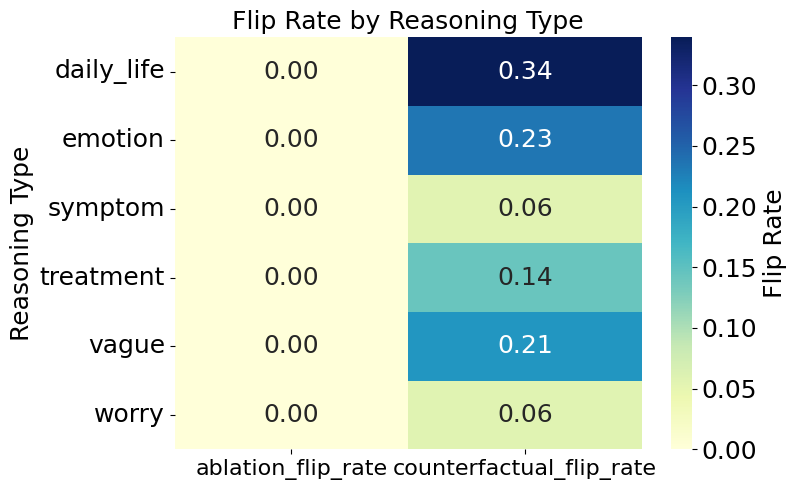

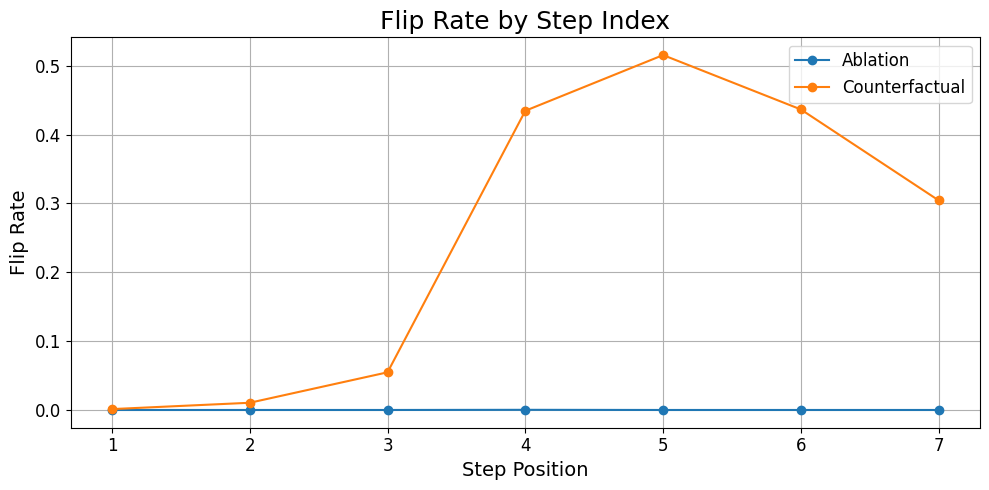

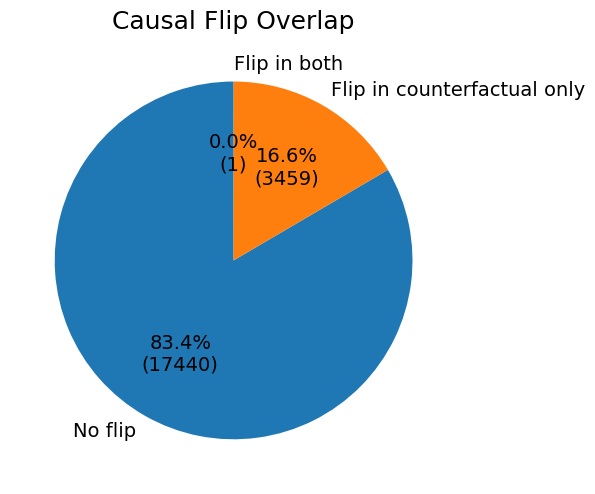

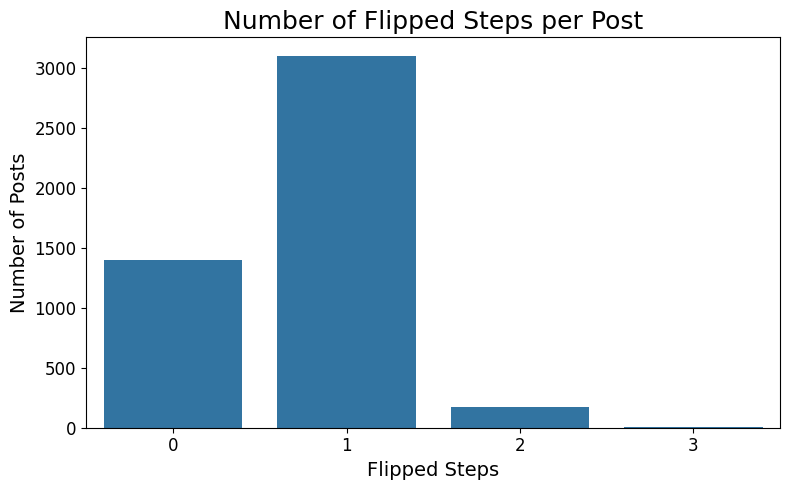

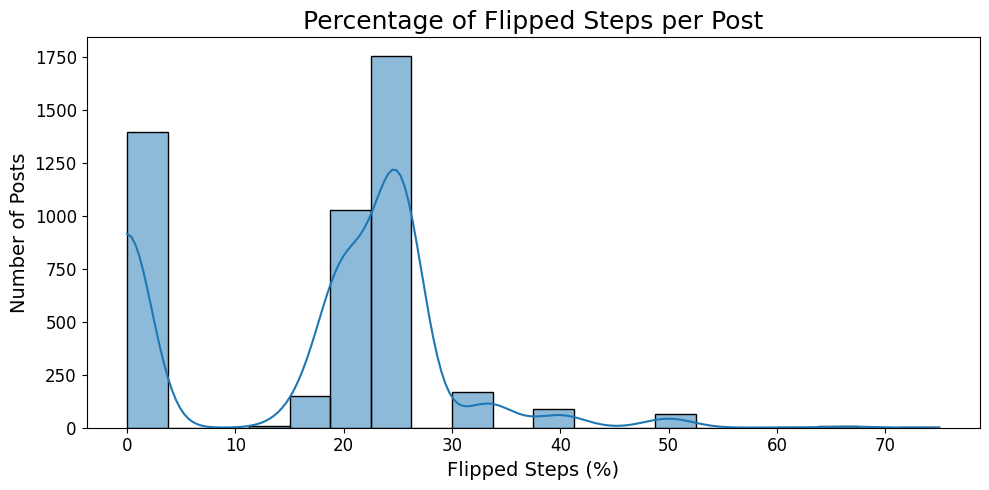


📊 Top Ablated Causal Steps:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           step_text  count
The relief they describe is new and tentative ("I pray this is permanent"), suggesting that the anxiety was a significant and ongoing issue before starting the medication.\n\nWhile the post describes recent improvement, the context clearly indicates that the author has been experiencing current anxiety symptoms that were severe enough to require multiple medication trials over three years. The improvement is so new and dramatic that it stands out against their long-term stru

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
ablation_df = pd.read_csv("/content/drive/MyDrive/SSTP/ablation_results.csv")
counterfactual_df = pd.read_csv("/content/drive/MyDrive/SSTP/counterfactual_ablation_full_results.csv")
labels_df = pd.read_csv("/content/drive/MyDrive/SSTP/reasoning_step_labels_full.csv")

# Standardize columns and merge labels
ablation_df = ablation_df.rename(columns={"step_removed_index": "step_index"})
counterfactual_df = counterfactual_df.rename(columns={"step_replaced": "step_index"})
ablation_df = ablation_df.merge(labels_df.rename(columns={"label": "reasoning_type"}), on=["row_index", "step_index"], how="left")
counterfactual_df = counterfactual_df.merge(labels_df.rename(columns={"label": "reasoning_type"}), on=["row_index", "step_index"], how="left")

# Summary stats
summary_stats = {
    "Total Steps (Ablation)": len(ablation_df),
    "Total Steps (Counterfactual)": len(counterfactual_df),
    "Flips (Ablation)": ablation_df["flip_occurred"].sum(),
    "Flips (Counterfactual)": counterfactual_df["flip_occurred"].sum(),
    "Unique Posts Analyzed": ablation_df["row_index"].nunique()
}
summary_df = pd.DataFrame(list(summary_stats.items()), columns=["Metric", "Value"])
print("\n📊 Summary Statistics:")
print(summary_df.to_string(index=False))

# Flip rate stats
ablation_by_type = ablation_df.groupby("reasoning_type")["flip_occurred"].mean().reset_index(name="ablation_flip_rate")
counter_by_type = counterfactual_df.groupby("reasoning_type")["flip_occurred"].mean().reset_index(name="counterfactual_flip_rate")
flip_rate_by_type = pd.merge(ablation_by_type, counter_by_type, on="reasoning_type")

ablation_by_position = ablation_df.groupby("step_index")["flip_occurred"].mean().reset_index(name="ablation_flip_rate")
counter_by_position = counterfactual_df.groupby("step_index")["flip_occurred"].mean().reset_index(name="counterfactual_flip_rate")

# Overlap computation
merged = pd.merge(
    ablation_df[["row_index", "step_index", "flip_occurred"]],
    counterfactual_df[["row_index", "step_index", "flip_occurred"]],
    on=["row_index", "step_index"],
    suffixes=("_ablation", "_counter")
)
def overlap_label(row):
    if row["flip_occurred_ablation"] and row["flip_occurred_counter"]:
        return "Flip in both"
    elif row["flip_occurred_ablation"]:
        return "Flip in ablation only"
    elif row["flip_occurred_counter"]:
        return "Flip in counterfactual only"
    return "No flip"
merged["flip_overlap"] = merged.apply(overlap_label, axis=1)
overlap_counts = merged["flip_overlap"].value_counts().reset_index(name="count").rename(columns={"index": "flip_overlap"})

# Per-post flip percentages
counter_step_counts = counterfactual_df.groupby("row_index").agg(
    total_steps=("step_index", "count"),
    flipped_steps=("flip_occurred", "sum")
).reset_index()
counter_step_counts["flip_percent"] = (counter_step_counts["flipped_steps"] / counter_step_counts["total_steps"]) * 100

# Top steps
top_ablation_steps = ablation_df[ablation_df["flip_occurred"]]["step_removed_text"].value_counts().head(5).reset_index()
top_ablation_steps.columns = ["step_text", "count"]
top_counter_steps = counterfactual_df[counterfactual_df["flip_occurred"]]["modified_step"].value_counts().head(5).reset_index()
top_counter_steps.columns = ["step_text", "count"]

# === Visualizations (with bigger fonts) ===

# Flip rate heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(
    flip_rate_by_type.set_index("reasoning_type"),
    annot=True,
    cmap="YlGnBu",
    fmt=".2f",
    annot_kws={"size": 14},
    cbar_kws={"label": "Flip Rate", "format": "%.2f"}
)
plt.title("Flip Rate by Reasoning Type", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()


# Flip rate by step position
plt.figure(figsize=(10, 5))
plt.plot(ablation_by_position["step_index"], ablation_by_position["ablation_flip_rate"], label="Ablation", marker="o")
plt.plot(counter_by_position["step_index"], counter_by_position["counterfactual_flip_rate"], label="Counterfactual", marker="o")
plt.title("Flip Rate by Step Index", fontsize=18)
plt.xlabel("Step Position", fontsize=14)
plt.ylabel("Flip Rate", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Pie chart with counts + %
def make_autopct(values):
    def inner_autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f"{pct:.1f}%\n({count})"
    return inner_autopct

plt.figure(figsize=(6, 6))
plt.pie(
    overlap_counts["count"],
    labels=overlap_counts["flip_overlap"],
    autopct=make_autopct(overlap_counts["count"]),
    startangle=90,
    textprops={'fontsize': 14}
)
plt.title("Causal Flip Overlap", fontsize=18)
plt.tight_layout()
plt.show()

# Bar chart: number of flipped steps per post
plt.figure(figsize=(8, 5))
sns.countplot(x="flipped_steps", data=counter_step_counts)
plt.title("Number of Flipped Steps per Post", fontsize=18)
plt.xlabel("Flipped Steps", fontsize=14)
plt.ylabel("Number of Posts", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Histogram: % of flipped steps per post
plt.figure(figsize=(10, 5))
sns.histplot(counter_step_counts["flip_percent"], bins=20, kde=True)
plt.title("Percentage of Flipped Steps per Post", fontsize=18)
plt.xlabel("Flipped Steps (%)", fontsize=14)
plt.ylabel("Number of Posts", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Display top flipped step examples
print("\n📊 Top Ablated Causal Steps:")
print(top_ablation_steps.to_string(index=False))

print("\n📊 Top Counterfactual Causal Steps:")
print(top_counter_steps.to_string(index=False))

print("\n📊 Flip Overlap Distribution:")
print(overlap_counts.to_string(index=False))

# Save qualitative tables
top_ablation_steps.to_csv("/content/drive/MyDrive/SSTP/top_ablated_causal_steps.csv", index=False)
top_counter_steps.to_csv("/content/drive/MyDrive/SSTP/top_counterfactual_causal_steps.csv", index=False)
print("✅ Top causal steps saved.")


In [ ]:
#Analysis on baseline metrics
import pandas as pd
from tabulate import tabulate
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

#Load data
df_full = pd.read_csv("/content/drive/MyDrive/SSTP/deepseek_full_results_cleaned.csv")
ablation_df = pd.read_csv("/content/drive/MyDrive/SSTP/ablation_results.csv")
counterfactual_df = pd.read_csv("/content/drive/MyDrive/SSTP/counterfactual_ablation_full_results.csv")
labels_df = pd.read_csv("/content/drive/MyDrive/SSTP/reasoning_step_labels_full.csv")

#Baseline evaluation

#Map predictions
prediction_map = {"Yes": 1, "No": 0}
df_full["pred_binary"] = df_full["prediction"].map(prediction_map)
df_full["true_binary"] = df_full["true_label"].astype(int)
df_eval = df_full.dropna(subset=["pred_binary", "true_binary"])

y_true = df_eval["true_binary"]
y_pred = df_eval["pred_binary"]

baseline_summary = {
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision": precision_score(y_true, y_pred),
    "Recall": recall_score(y_true, y_pred),
    "F1 Score": f1_score(y_true, y_pred)
}
baseline_report = classification_report(y_true, y_pred, output_dict=True)

#Merge reasoning type labels
ablation_df = ablation_df.rename(columns={"step_removed_index": "step_index"})
counterfactual_df = counterfactual_df.rename(columns={"step_replaced": "step_index"})
labels_df = labels_df.rename(columns={"label": "reasoning_type"})

ablation_df = ablation_df.merge(labels_df, on=["row_index", "step_index"], how="left")
counterfactual_df = counterfactual_df.merge(labels_df, on=["row_index", "step_index"], how="left")

true_labels = df_full[["row_index", "true_label"]]
ablation_df = ablation_df.merge(true_labels, on="row_index", how="left")
counterfactual_df = counterfactual_df.merge(true_labels, on="row_index", how="left")

#Flip evaluation for each reasoning type
def compute_flip_metrics(df, label_col="reasoning_type", pred_col="ablated_prediction"):
    df = df[df["flip_occurred"]].copy()
    df[pred_col] = df[pred_col].astype(str).str.lower().str.strip()
    df = df[df[pred_col].isin(["yes", "no"])]
    df["true_label"] = pd.to_numeric(df["true_label"], errors="coerce")
    df = df.dropna(subset=["true_label", pred_col])
    df["y_pred"] = df[pred_col].map({"yes": 1, "no": 0})
    df["y_true"] = df["true_label"].astype("Int64")
    df = df.dropna(subset=["y_true", "y_pred"])

    grouped = df.groupby(label_col)
    results = []
    for name, group in grouped:
        results.append({
            "reasoning_type": name,
            "count": len(group),
            "accuracy": accuracy_score(group["y_true"], group["y_pred"]),
            "precision": precision_score(group["y_true"], group["y_pred"], zero_division=0),
            "recall": recall_score(group["y_true"], group["y_pred"], zero_division=0),
            "f1_score": f1_score(group["y_true"], group["y_pred"], zero_division=0)
        })

    return pd.DataFrame(results)

ablation_flip_metrics = compute_flip_metrics(ablation_df, pred_col="ablated_prediction")
counter_flip_metrics = compute_flip_metrics(counterfactual_df, pred_col="new_prediction")

#Helpful flip rate (flips that matched ground truth)
def helpful_flip_rate(df, pred_col="ablated_prediction"):
    df = df[df["flip_occurred"]].copy()
    df[pred_col] = df[pred_col].astype(str).str.lower().str.strip()
    df = df[df[pred_col].isin(["yes", "no"])]
    df["true_label"] = pd.to_numeric(df["true_label"], errors="coerce")
    df = df.dropna(subset=["true_label", pred_col])
    pred_binary = df[pred_col].map({"yes": 1, "no": 0})
    true_binary = df["true_label"].astype("Int64")
    df["match"] = pred_binary == true_binary
    return df.groupby("reasoning_type")["match"].mean().reset_index(name="helpful_flip_rate")

ablation_helpful = helpful_flip_rate(ablation_df, pred_col="ablated_prediction")
counter_helpful = helpful_flip_rate(counterfactual_df, pred_col="new_prediction")

#Print results
print("📊 Baseline Metrics:")
print(tabulate(baseline_df, headers='keys', tablefmt='fancy_grid'), end="\n\n")

print("🔍 Ablation Flip Metrics:")
print(tabulate(ablation_flip_metrics, headers='keys', tablefmt='fancy_grid'), end="\n\n")

print("🔁 Counterfactual Flip Metrics:")
print(tabulate(counter_flip_metrics, headers='keys', tablefmt='fancy_grid'), end="\n\n")

print("✅ Helpful Ablation Flip Rates:")
print(tabulate(ablation_helpful, headers='keys', tablefmt='fancy_grid'), end="\n\n")

print("✅ Helpful Counterfactual Flip Rates:")
print(tabulate(counter_helpful, headers='keys', tablefmt='fancy_grid'), end="\n\n")



📊 Baseline Metrics:
╒════╤════════════╤═════════════╤══════════╤════════════╕
│    │   Accuracy │   Precision │   Recall │   F1 Score │
╞════╪════════════╪═════════════╪══════════╪════════════╡
│  0 │   0.852207 │    0.877202 │ 0.944459 │   0.909589 │
╘════╧════════════╧═════════════╧══════════╧════════════╛

🔍 Ablation Flip Metrics:
╒════╤══════════════════╤═════════╤════════════╤═════════════╤══════════╤════════════╕
│    │ reasoning_type   │   count │   accuracy │   precision │   recall │   f1_score │
╞════╪══════════════════╪═════════╪════════════╪═════════════╪══════════╪════════════╡
│  0 │ emotion          │       1 │          0 │           0 │        0 │          0 │
╘════╧══════════════════╧═════════╧════════════╧═════════════╧══════════╧════════════╛

🔁 Counterfactual Flip Metrics:
╒════╤══════════════════╤═════════╤════════════╤═════════════╤═══════════╤════════════╕
│    │ reasoning_type   │   count │   accuracy │   precision │    recall │   f1_score │
╞════╪═══════════════